In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings

In [5]:
df = pd.read_csv("iar_ocupaciones.csv")
df = df.drop_duplicates()
df['Fecha_hoy'] = pd.to_datetime(df['Fecha_hoy'])
df = df[df['moneda_cve'] != 1]

In [6]:
# Dataframe for numerical columns and date
df_num = df[['Fecha_hoy', 'ing_hab']]
df_num['daily'] = df['Fecha_hoy'].dt.strftime('%Y-%m-%d')
df_num = df_num.drop("Fecha_hoy", axis=1)
df_num.head()

/var/folders/jh/wqv8k9v13k7_v10t9h68wrbh0000gn/T/ipykernel_49233/3287129472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['daily'] = df['Fecha_hoy'].dt.strftime('%Y-%m-%d')


,ing_hab,daily
0,0.000000,2021-11-15
1,0.000000,2021-11-15
3,0.000000,2021-11-15
4,0.000000,2021-11-15
7,142.833688,2021-11-15


In [7]:
df_num = df_num.groupby(by="daily").agg({
    'ing_hab': 'sum'
})
df_num.reset_index(inplace=True)

<Figure size 640x480 with 0 Axes>

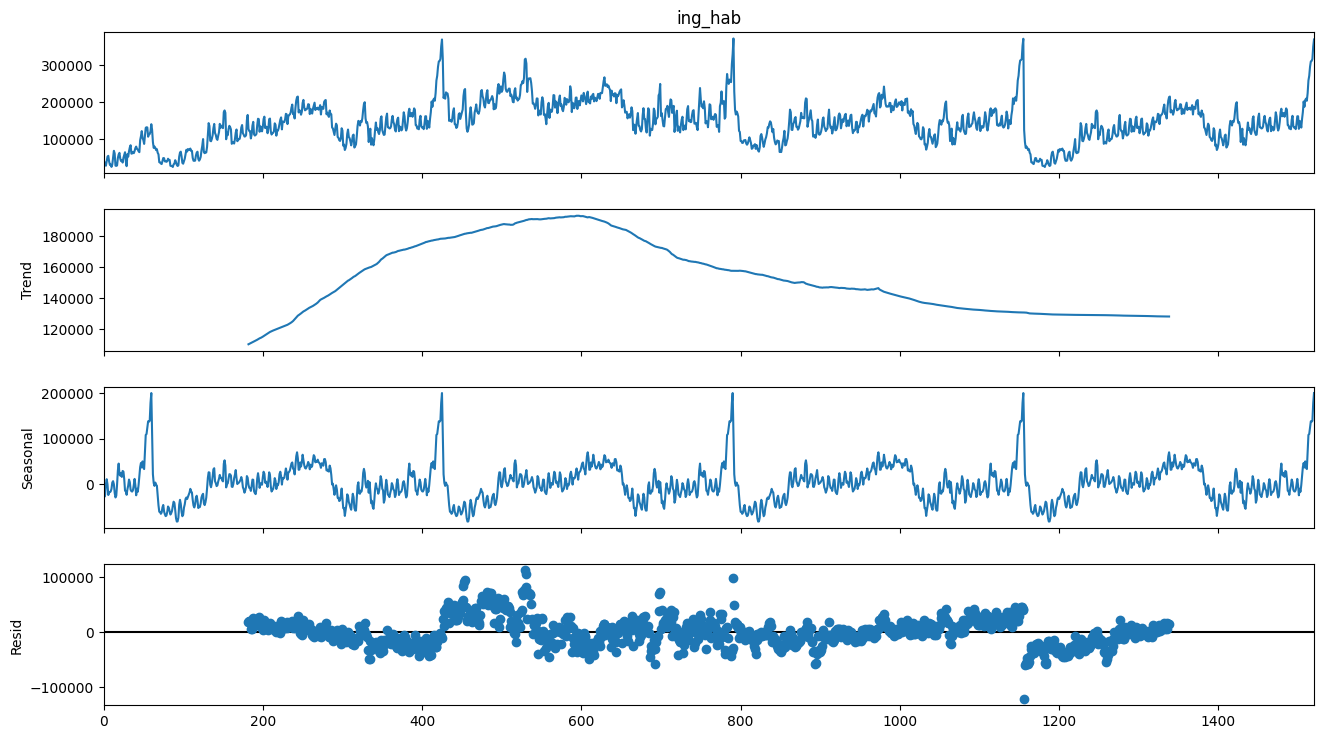

In [8]:
decomposition = seasonal_decompose(df_num['ing_hab'], period=365)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

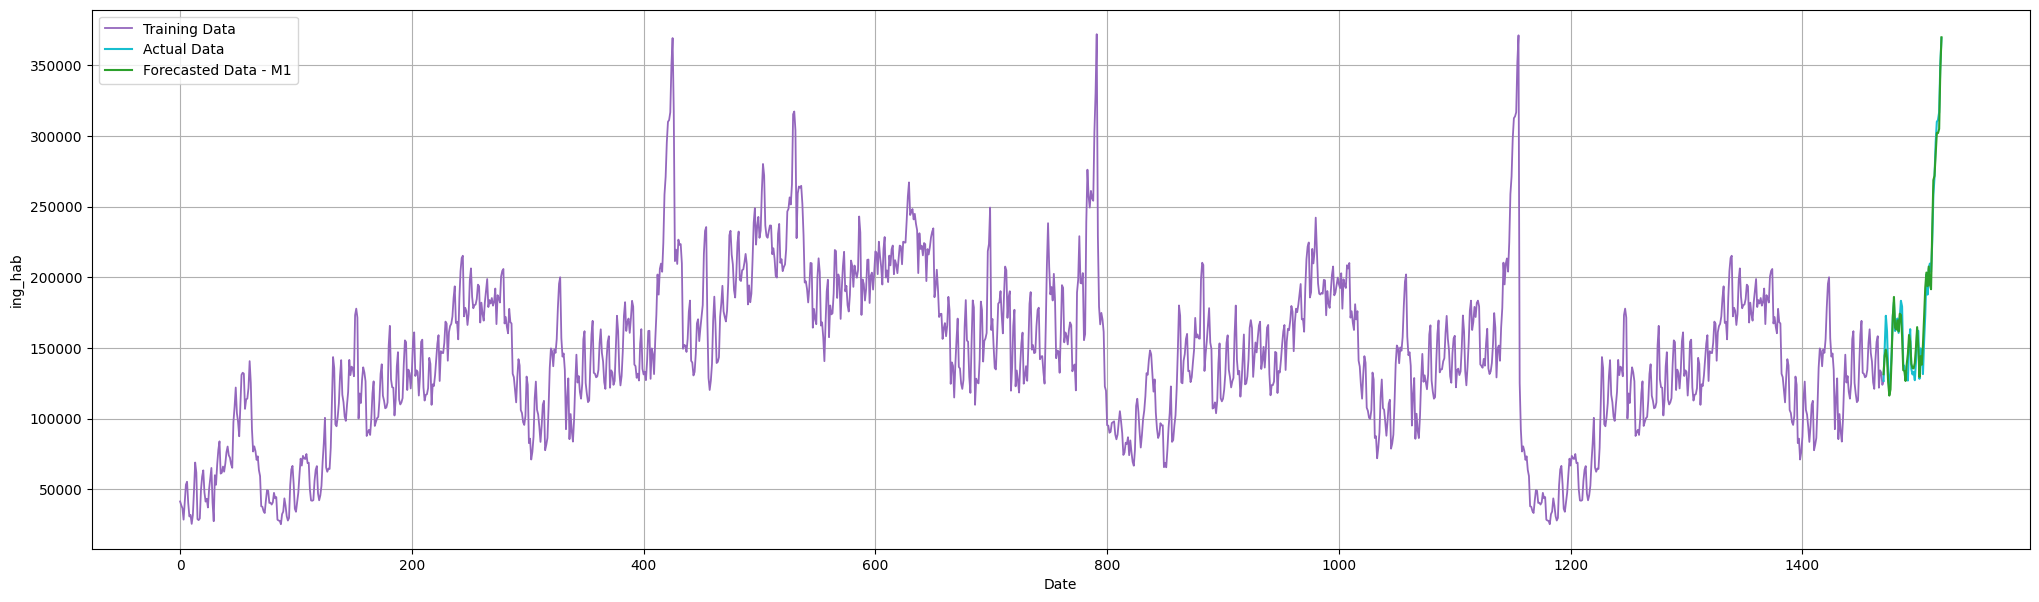

In [28]:
warnings.filterwarnings('ignore')

testing_cycles = 1
# Split the data into train and test; tenemos 27 ciclos
train_size = (int(len(df_num)//30) - testing_cycles)*30
train, test = df_num[0:train_size], df_num[train_size:len(df_num)]

# Fit the model on the training dataset
model_train1 = ExponentialSmoothing(train['ing_hab'], trend='mul', seasonal='mul', seasonal_periods=365, use_boxcox=True, initialization_method="estimated")
model_train_fit1 = model_train1.fit()
# Forecast on the test dataset
test_forecast1 = model_train_fit1.forecast(len(test))
test_forecast_series1 = pd.Series(test_forecast1, index=test.index)

#Plot config
font_name = "Serif"

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(25,7))
plt.plot(df_num[0:train_size+1]['ing_hab'],linewidth=1.3, c='tab:purple', label='Training Data')
plt.plot(test['ing_hab'], label='Actual Data', color='tab:cyan')
plt.plot(test_forecast_series1, label='Forecasted Data - M1', color='tab:green')
plt.title('')
plt.xlabel('Date')
plt.ylabel('ing_hab')
plt.legend(loc='best')
plt.grid()
plt.show()

Root Mean Squared Error (RMSE) - M1: 9769.471700858203
Mean Absolute Percent Error - M1: 0.04659264103790605


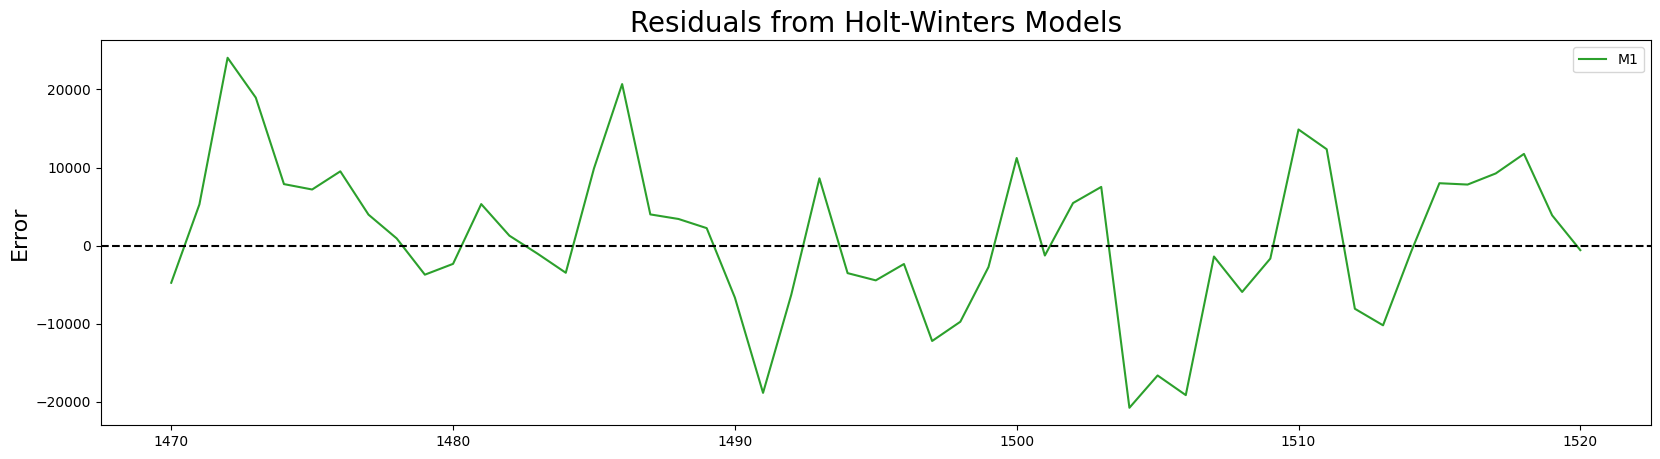

In [29]:
residuals1 = test['ing_hab'] - test_forecast_series1

#Plot config
font_name = "Serif"

plt.figure(figsize=(20,5))
plt.plot(residuals1, label='M1', color='tab:green')
#defining the ideal residual baseline
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from Holt-Winters Models', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.legend(loc='best')

rmse1 = mean_squared_error(test['ing_hab'], test_forecast_series1)**0.5
print('Root Mean Squared Error (RMSE) - M1:', rmse1)
print('Mean Absolute Percent Error - M1:', round(np.mean(abs(residuals1/test['ing_hab'])),len(residuals1)))